In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-05-12 00:00:00+00:00    49150.535156
2021-05-13 00:00:00+00:00    49716.191406
2021-05-14 00:00:00+00:00    49880.535156
2021-05-15 00:00:00+00:00    46760.187500
2021-05-16 00:00:00+00:00    45610.812500
Name: Close, Length: 2430, dtype: float64


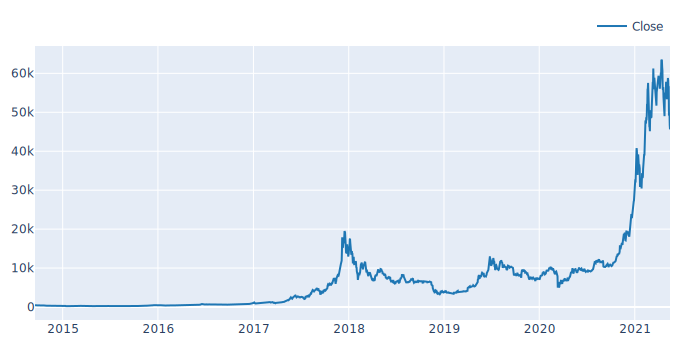

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

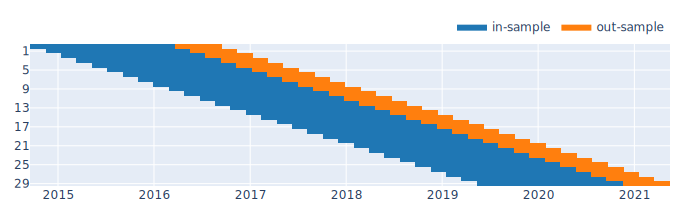

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.517865
2     1.255552
3     1.150979
4     1.614115
5     1.735473
6     2.364054
7     2.033642
8     2.283147
9     2.769900
10    2.730317
11    3.002259
12    2.667361
13    2.336815
14    1.973911
15    1.766458
16    1.648238
17    0.566080
18    0.444808
19    0.562995
20    0.127880
21    0.413215
22    0.522613
23    0.359669
24    0.353052
25    0.399633
26    0.944417
27    1.205781
28    1.275121
29    1.102657
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.093530
                          2            0.420322
                          3            0.449279
                          4            0.645027
                                         ...   
48           49           25           0.821348
                          26           0.034521
                          27          -0.028890
                          28          -0.521243
                          29          -1.126778
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (20, 41,  4),
            (40, 43,  5),
            (41, 42,  6),
            (33, 46,  7),
            (31, 47,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 22, 12),
            (10, 21, 13),
            (10, 22, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (10, 22, 18),
            (17, 22, 19),
            (17, 23, 20),
            (13, 21, 21),
            (13, 21, 22),
            (18, 21, 23),
            (18, 21, 24),
            (18, 21, 25),
            (13, 21, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [20 41]
 [40 43]
 [41 42]
 [33 46]
 [31 47]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 21]
 [10 22]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 23]
 [13 21]
 [13 21]
 [18 21]
 [18 21]
 [18 21]
 [13 21]
 [13 20]
 [13 20]
 [13 20]]


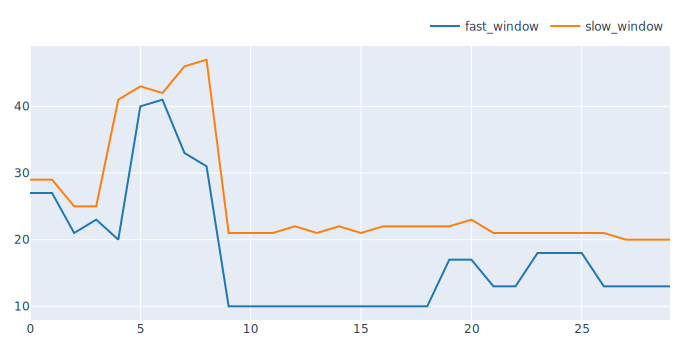

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     1.934571
2     1.675314
3     2.633584
4     2.905083
5     3.428684
6     3.548628
7     3.442387
8     3.771082
9     1.856521
10    1.471389
11   -1.190893
12   -1.046378
13   -0.809331
14   -2.122871
15   -1.492398
16   -0.333313
17    2.778420
18    3.357516
19    1.522591
20    0.234074
21   -0.247918
22   -0.222001
23    0.874355
24    0.720986
25    1.897656
26    3.193577
27    4.693180
28    4.804021
29    2.703808
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.517213
                          2            1.725101
                          3            0.166028
                          4            1.899190
                                         ...   
48           49           25          -1.449657
                          26          -1.036444
                          27           2.847515
                          28           4.252549
                          29           0.400744
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.210568
21         25         2            1.793432
23         25         3            1.430223
20         41         4            0.142040
40         43         5            2.151938
41         42         6            0.811184
33         46         7           -1.387300
31         47         8            0.948166
10         21         9            3.119703
                      10           2.523699
                      11           1.731508
           22         12           1.636620
           21         13           0.960527
           22         14           1.732295
           21         15          -0.223707
           22         16           1.732838
                      17           2.597476
                      18           0.763577
17         22         19           0.726810
           23         20          -0.187969
13         21         21           1.316547


In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

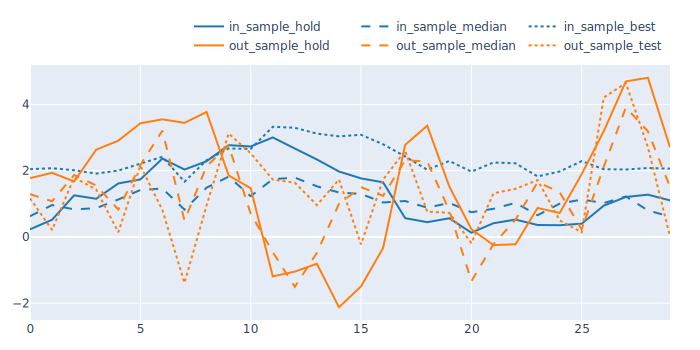

In [24]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()